In [2]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.utils import powerlaw_sequence
from networkx.algorithms.dag import dag_longest_path

To be discussed

1. Deal with not connected components
2. Deal with cyclic graph
3. Start from root

# 1.Generate graph by Configuration Model

Generate a degree sequence with **nodeN** nodes



In [13]:
nodeN = 20
mean_degree = 2

In [14]:
# Generate degree sequence
# sequence = nx.random_powerlaw_tree_sequence(nodeN, tries=5000)
sequence = np.random.poisson(mean_degree, nodeN)

while (np.sum(sequence) % 2 !=0):
    sequence = np.random.poisson(mean_degree, nodeN)

# Generate Graph according to the degree sequence
G = nx.configuration_model(sequence)

# Remove parallel edges
G = nx.Graph(G)

# Remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

Generated Graph

**Notice:** Generated grapsh might have **cycles** and **not** connected

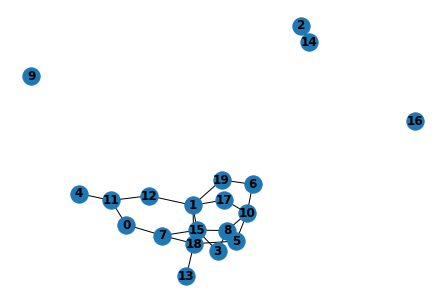

In [15]:
nx.draw(G, with_labels=True, font_weight='bold')

# 2. Decide nodes' mask wearing states

## P(A person wears a mask) = m

In [16]:
m = 0.6

Generate the mask wearing states of each node.

In [17]:
# A list of 1 and 0 indicating mask wearing or not
# 1 means wear mask, 0 means not wearing a mask
masks = np.random.binomial(1, m, nodeN)

# Node idx
nodes = np.linspace(0, nodeN - 1, nodeN, dtype = int)
# Dict of node attributes
mask_dict = dict(zip(nodes, masks))

# Set nodes attributes
nx.set_node_attributes(G, mask_dict, 'mask')

Check nodes's mask wearing states

In [18]:
masks

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

# 3. Init nodes infection states to all 0 (not infected)

In [19]:
# Init all nodes to be healthy
infected = np.zeros(nodeN, dtype = int)

# Node idx
nodes = np.linspace(0, nodeN - 1, nodeN, dtype = int)

# Dict of node attributes
infected_dict = dict(zip(nodes, infected))

# Set nodes attributes
nx.set_node_attributes(G, infected_dict, 'infected')

Check nodes' infected attributes

In [20]:
infected

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# 3. Generate the BFS tree structures for each components
Get all the connected components

In [21]:
components = list(nx.connected_components(G))
# print([len(c) for c in components])

Randomly select roots for trees

In [22]:
# Roots stores the randomly selected root for each components
roots = []
# biggest_component_size = max(len(c) for c in components)
# problem_components = [c for c in components if len(c) != biggest_component_size]
for component in components:
    roots.append(random.choice(list(component)))

In [23]:
roots

[8, 14, 9, 16]

Convert the components to a BFS tree-like structure, with randomly selected roots

In [24]:
# Trees stores all the tree-structured components
Trees = []
for root in roots:
    T = nx.bfs_tree(G, source = root)
    nx.set_node_attributes(T, mask_dict, 'mask')
    nx.set_node_attributes(T, infected_dict, 'infected')
    Trees.append(T)

Look at the tree-like graphs

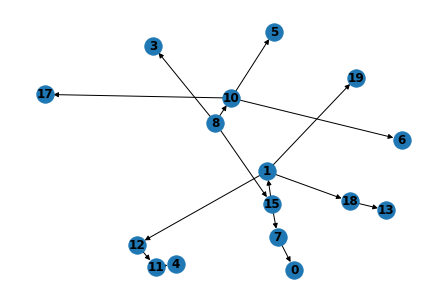

In [25]:
nx.draw(Trees[0], with_labels=True, font_weight='bold')

# 4. Starting the infection process 

**Notice**
Infection starts from root to the leaves

| Infectious    |  Susceptible   | Transmissibillity     | Notation |
| :------------- | :----------: | :----------- | :----------- |
| 1             | 0              | T * T_mask^2 * m      | T_1 |
| 1             | 1              | T * T_mask * (1 - m)  | T_2 |
| 0             | 0              | T * (1 - m)           | T_3 |
| 0             | 1              | T * T_mask * m        | T_4 |




Parameters setup

In [26]:
T_mask = 0.1
T = 0.8
# Round T to roundN digits
roundN = 5

In [27]:
T1 = round(T * T_mask * T_mask * m, roundN)
T2 = round(T * T_mask * (1 - m), roundN)
T3 = round(T * (1 - m), roundN)
T4 = round(T * T_mask * m , roundN)

Q1 = T1 * (1 - m) + T2 * m
Q2 = T3 * (1 - m) + T4 * m

mu11 = T2 * m / Q1
mu12 = T1 * (1 - m) / Q1
mu22 = T3 * (1 - m) / Q2
mu21 = T4 * m / Q2

trans_dict = {'Q1': Q1,
              'Q2': Q2}

print("Q1: %.5f" %Q1)
print("Q2: %.5f" %Q2)

print("mu11: %.5f" %mu11)
print("mu12: %.5f" %mu12)
print("mu22: %.5f" %mu22)
print("mu21: %.5f" %mu21)

Q1: 0.02112
Q2: 0.15680
mu11: 0.90909
mu12: 0.09091
mu22: 0.81633
mu21: 0.18367


## Traverse from the root nodes using BFS search

Starting with 1 seed

In [28]:

for idx, tree in enumerate(Trees): 
    print("TREE No.", idx)
    
    edge_attr = dict()
    root = roots[idx]
    dfs_edges = list(nx.bfs_edges(tree, source = root))
    total_depth = nx.dag_longest_path_length(tree)
    
    nx.set_node_attributes(tree, infected_dict, 'infected')
    nx.set_node_attributes(tree, {root: 1}, 'infected') # Let root node be infected by nature

    
    for depth in range(1, total_depth + 1): # Transmitted level by level
        print('LEVEL %d' % depth)
        
        if depth == 1: # Get only this level's node pairs
            dfs_edges = list(nx.dfs_edges(tree, source = root, depth_limit = depth))
            
        else: 
            
            dfs_edges = set(nx.dfs_edges(tree, source = root, depth_limit = depth)) - \
                        set(nx.dfs_edges(tree, source = root, depth_limit = depth - 1))
        
        
        for father, son in dfs_edges: # Check each node pairs in this level
            print("(%d, %d), node %d is_infected = %d" %(father, son, father, tree.nodes[father]['infected'] ))
            
            if tree.nodes[father]['infected'] == 1: 
                
                
                
                # Decide which transmissibility
                if tree.nodes[father]['mask'] == 1:
                    T_edge = 'Q1'
                else:
                    T_edge = 'Q2'
                # Set the 'Transmissibility'edge attrs
                edge_attr[(father,son)] = {'T': T_edge}
                nx.set_edge_attributes(tree, edge_attr)
            
            
            
                # Decide if the susceptible is infected
                is_infected = int(random.random() < trans_dict[T_edge])
                # Set the 'infected' node attr accordingly
                nx.set_node_attributes(tree, {son: is_infected}, 'infected')
                
                if is_infected:
                    print("node %d is infected with %s" %(son, T_edge))
                
                
                
                # Decide if the susceptible mutates
                if tree.nodes[son]['mask'] == 1: # mu11 or mu12
                    
                    # Decide if the susceptible is mutated
                    is_mutated = int(random.random() > mu11)
                    # Set the 'mask' node attr accordingly
                    if is_mutated: # mask: 1 -> 0
                        nx.set_node_attributes(tree, {son: 0}, 'mask')
                        print("node %d is mutated to not wearking mask!" %(son))
                        
                else:
                    
                    # Decide if the susceptible is mutated
                    is_mutated = int(random.random() > mu22)
                    # Set the 'mask' node attr accordingly
                    if is_mutated: # mask: 0 -> 1
                        nx.set_node_attributes(tree, {son: 1}, 'mask')
                        print("node %d is mutated to wearking mask!" %(son))
                        

TREE No. 0
LEVEL 1
(8, 3), node 8 is_infected = 1
node 3 is mutated to wearking mask!
(8, 15), node 8 is_infected = 1
(8, 10), node 8 is_infected = 1
node 10 is infected with Q2
LEVEL 2
(10, 5), node 10 is_infected = 1
node 5 is mutated to not wearking mask!
(10, 17), node 10 is_infected = 1
(10, 6), node 10 is_infected = 1
(15, 1), node 15 is_infected = 0
(15, 7), node 15 is_infected = 0
LEVEL 3
(1, 18), node 1 is_infected = 0
(1, 19), node 1 is_infected = 0
(7, 0), node 7 is_infected = 0
(1, 12), node 1 is_infected = 0
LEVEL 4
(18, 13), node 18 is_infected = 0
(12, 11), node 12 is_infected = 0
LEVEL 5
(11, 4), node 11 is_infected = 0
TREE No. 1
LEVEL 1
(14, 2), node 14 is_infected = 1
node 2 is mutated to not wearking mask!
TREE No. 2
TREE No. 3


## Look at the infected result

change i to look at different sub-trees

root node: 14


{(14, 2): Text(62.605, 23.319499999999998, "{'T': 'Q2'}")}

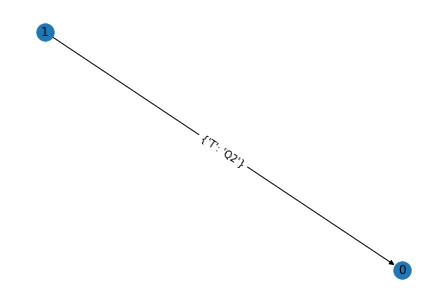

In [30]:
i = 1
pos = nx.nx_agraph.graphviz_layout(Trees[i])

nx.draw(Trees[i], pos, with_labels = False)

# # Show nodes' attrs
node_labels = nx.get_node_attributes(Trees[i],'infected')
nx.draw_networkx_labels(Trees[i], pos, labels = node_labels)
print("root node:", roots[i])
# Show edges' attrs
edge_labels = nx.get_edge_attributes(Trees[i],'T')
nx.draw_networkx_edge_labels(Trees[i], pos, labels = edge_labels)

In [31]:
E_S = []
for idx, tree  in enumerate(Trees):
    res = np.array(list(tree.nodes.data('infected')))
    print(res)
    es = sum(res[:,1]) / res.shape[0]
    E_S.append(es)
    print("Tree %d Epidemic Size: %.3f" %(idx, es))

print('Avg Epidemic Size:', sum(E_S) / len(E_S))

[[ 8  1]
 [ 3  0]
 [15  0]
 [10  1]
 [ 1  0]
 [ 7  0]
 [ 5  0]
 [ 6  0]
 [17  0]
 [19  0]
 [12  0]
 [18  0]
 [ 0  0]
 [11  0]
 [13  0]
 [ 4  0]]
Tree 0 Epidemic Size: 0.125
[[14  1]
 [ 2  0]]
Tree 1 Epidemic Size: 0.500
[[9 1]]
Tree 2 Epidemic Size: 1.000
[[16  1]]
Tree 3 Epidemic Size: 1.000
Avg Epidemic Size: 0.65625
